# Bitcoin Fiyat Tahmini - Lasso Regression ile Feature Selection

**Veri Madenciliği Güz Dönemi Vize Ödevi**

## Ödev Amacı
Bu projede Bitcoin (BTC-USD) fiyatlarını tahmin etmek için **Lasso Regression** algoritmasını kullandım. Lasso'nun en önemli özelliği **L1 Regularization** ile otomatik **Feature Selection** yapabilmesidir. 

## Neden Lasso?
- **L1 Regularization**: Gereksiz özelliklerin katsayısını sıfıra indirir
- **Otomatik Feature Selection**: Önemli özellikleri kendisi seçer
- **Overfitting Önleme**: Düzenlileştirme sayesinde modeli genelleştirir
- **Yorumlanabilirlik**: Hangi özelliklerin önemli olduğunu görebiliriz

## Kullanılan Feature Selection Yöntemleri
1. **Lasso (L1 Regularization)** - Ana yöntem
2. **Correlation-based Selection** - Yüksek korelasyonlu özellikleri filtrele
3. **Variance Threshold** - Düşük varyanslı özellikleri çıkar

## Veri Seti
- **Kaynak**: Yahoo Finance API (yfinance)
- **Veri**: BTC-USD günlük fiyatlar (son 2 yıl)
- **Özellikler**: Lag değerleri (30 günlük geçmiş fiyatlar)

In [17]:
# Gerekli kütüphaneleri yükle
!pip install pandas yfinance numpy matplotlib scikit-learn seaborn -q

In [18]:
# Kütüphaneleri import et
import pandas as pd
import yfinance as yf
import numpy as np
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn kütüphaneleri
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Uyarıları kapat
import warnings
warnings.filterwarnings('ignore')

# Görselleştirme ayarları
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Tüm kütüphaneler başarıyla yüklendi.")

✓ Tüm kütüphaneler başarıyla yüklendi.


In [19]:
# 1. VERİ ÇEKME
# Yahoo Finance'ten Bitcoin verilerini çekiyorum
print("=" * 70)
print("1. ADIM: VERİ ÇEKME")
print("=" * 70)

# Son 2 yıllık veri alıyorum (730 gün)
today = date.today()
end_date = today.strftime("%Y-%m-%d")
start_date = (today - timedelta(days=730)).strftime("%Y-%m-%d")

# BTC-USD verilerini indir
data = yf.download('BTC-USD', start=start_date, end=end_date, progress=False)

# Bazı yfinance versiyonlarında sütunlar MultiIndex olabiliyor, düzeltiyorum
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# Index'i sıfırla ve sadece ihtiyacım olan sütunları al
data.reset_index(inplace=True)
data = data[["Date", "Open", "High", "Low", "Close", "Volume"]]

print(f"✓ {len(data)} günlük Bitcoin verisi çekildi.")
print(f"✓ Tarih aralığı: {data['Date'].min().date()} - {data['Date'].max().date()}")
print(f"✓ Veri boyutu: {data.shape}")

# Orjinal veriyi sakla (sonradan görselleştirmede kullanacağım)
data_full = data.copy()

# İlk 5 satırı göster
print("\nİlk 5 satır:")
print(data.head())

1. ADIM: VERİ ÇEKME
✓ 730 günlük Bitcoin verisi çekildi.
✓ Tarih aralığı: 2023-11-25 - 2025-11-23
✓ Veri boyutu: (730, 6)

İlk 5 satır:
Price       Date          Open          High           Low         Close  \
0     2023-11-25  37721.414062  37892.429688  37617.417969  37796.792969   
1     2023-11-26  37796.828125  37820.300781  37162.750000  37479.121094   
2     2023-11-27  37454.191406  37559.355469  36750.128906  37254.167969   
3     2023-11-28  37247.992188  38368.480469  36891.089844  37831.085938   
4     2023-11-29  37826.105469  38366.113281  37612.632812  37858.492188   

Price       Volume  
0       9099571165  
1      13744796068  
2      19002925720  
3      21696137014  
4      20728546658  


In [20]:
# 2. ÖZELLİK MÜHENDİSLİĞİ (FEATURE ENGINEERING)
# Time series tahmininde "lag features" kullanıyorum
# Yani geçmiş günlerin fiyatlarını özellik olarak kullanıyorum
print("\n" + "=" * 70)
print("2. ADIM: ÖZELLİK MÜHENDİSLİĞİ")
print("=" * 70)

target_col = 'Close'  # Tahmin edeceğim değişken: Kapanış fiyatı
n_lags = 30  # Son 30 günün fiyatlarını özellik olarak kullanacağım

# Her gün için önceki 30 günün fiyatlarını özellik olarak ekle
print(f"✓ {n_lags} adet lag özelliği oluşturuluyor...")
for i in range(1, n_lags + 1):
    data[f'lag_{i}'] = data[target_col].shift(i)
    # shift(i): i gün önceki değeri getir
    # Örnek: lag_1 = dünün fiyatı, lag_2 = 2 gün önceki fiyat...

# NaN değerleri var çünkü ilk 30 günün geçmişi yok, onları çıkar
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

print(f"✓ NaN değerler temizlendi.")
print(f"✓ Final veri boyutu: {data.shape}")
print(f"✓ Toplam özellik sayısı: {n_lags}")

# Örnek olarak ilk birkaç satırı göster
print("\nÖzellik mühendisliği sonrası örnek veriler:")
print(data[['Date', 'Close', 'lag_1', 'lag_2', 'lag_30']].head(10))


2. ADIM: ÖZELLİK MÜHENDİSLİĞİ
✓ 30 adet lag özelliği oluşturuluyor...
✓ NaN değerler temizlendi.
✓ Final veri boyutu: (700, 36)
✓ Toplam özellik sayısı: 30

Özellik mühendisliği sonrası örnek veriler:
Price       Date         Close         lag_1         lag_2        lag_30
0     2023-12-25  43613.140625  43016.117188  43739.542969  37796.792969
1     2023-12-26  42520.402344  43613.140625  43016.117188  37479.121094
2     2023-12-27  43442.855469  42520.402344  43613.140625  37254.167969
3     2023-12-28  42627.855469  43442.855469  42520.402344  37831.085938
4     2023-12-29  42099.402344  42627.855469  43442.855469  37858.492188
5     2023-12-30  42156.902344  42099.402344  42627.855469  37712.746094
6     2023-12-31  42265.187500  42156.902344  42099.402344  38688.750000
7     2024-01-01  44167.332031  42265.187500  42156.902344  39476.332031
8     2024-01-02  44957.968750  44167.332031  42265.187500  39978.390625
9     2024-01-03  42848.175781  44957.968750  44167.332031  41980.09

In [21]:
# 2.1. FEATURE SELECTION - ADIM 1: Correlation-Based Selection
# Hedef değişkenle korelasyonu çok düşük olan özellikleri filtreleyelim
print("\n" + "-" * 70)
print("FEATURE SELECTION - Yöntem 1: Correlation-Based Selection")
print("-" * 70)

# Tüm lag özelliklerini al
feature_cols = [f'lag_{i}' for i in range(1, n_lags + 1)]
X = data[feature_cols]
y = data[target_col]

# Her özelliğin target ile korelasyonunu hesapla
correlations = X.corrwith(y).abs().sort_values(ascending=False)

print("✓ Her özelliğin Close fiyatıyla korelasyonu:")
print(correlations.head(10))

# Korelasyonu 0.7'den yüksek olanları seç (eşik değeri)
correlation_threshold = 0.7
selected_features_corr = correlations[correlations > correlation_threshold].index.tolist()

print(f"\n✓ Korelasyon eşiği: {correlation_threshold}")
print(f"✓ Seçilen özellik sayısı: {len(selected_features_corr)}/{len(feature_cols)}")
print(f"✓ Seçilen özellikler: {selected_features_corr[:10]}...")  # İlk 10'unu göster


----------------------------------------------------------------------
FEATURE SELECTION - Yöntem 1: Correlation-Based Selection
----------------------------------------------------------------------
✓ Her özelliğin Close fiyatıyla korelasyonu:
Price
lag_1     0.996203
lag_2     0.992833
lag_3     0.989458
lag_4     0.986159
lag_5     0.982872
lag_6     0.979619
lag_7     0.976678
lag_8     0.973519
lag_9     0.970695
lag_10    0.967839
dtype: float64

✓ Korelasyon eşiği: 0.7
✓ Seçilen özellik sayısı: 30/30
✓ Seçilen özellikler: ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10']...


In [22]:
# 2.2. FEATURE SELECTION - ADIM 2: Variance Threshold
# Varyansı çok düşük olan özellikleri çıkar (çünkü bilgi taşımazlar)
print("\n" + "-" * 70)
print("FEATURE SELECTION - Yöntem 2: Variance Threshold")
print("-" * 70)

# Sadece korelasyonla seçilen özellikler üzerinde çalış
X_corr_selected = X[selected_features_corr]

# Varyans eşiğini belirle (normalize edilmiş veriler için)
# Önce normalize et
from sklearn.preprocessing import StandardScaler
scaler_temp = StandardScaler()
X_normalized = scaler_temp.fit_transform(X_corr_selected)

# Varyans eşiği uygula
variance_threshold = 0.1
selector = VarianceThreshold(threshold=variance_threshold)
selector.fit(X_normalized)

# Hangi özellikler seçildi?
selected_features_variance = X_corr_selected.columns[selector.get_support()].tolist()

print(f"✓ Varyans eşiği: {variance_threshold}")
print(f"✓ Varyans filtresinden geçen özellik sayısı: {len(selected_features_variance)}/{len(selected_features_corr)}")
print(f"✓ Final özellikler: {selected_features_variance}")

# Artık bu özelliklerle devam edeceğim
feature_cols_final = selected_features_variance
X_final = X[feature_cols_final]

print(f"\n✓ Feature Selection tamamlandı!")
print(f"✓ Başlangıç: {n_lags} özellik")
print(f"✓ Correlation filtresi sonrası: {len(selected_features_corr)} özellik")
print(f"✓ Variance filtresi sonrası: {len(feature_cols_final)} özellik")
print(f"✓ İndirgeme oranı: %{(1 - len(feature_cols_final)/n_lags)*100:.1f}")


----------------------------------------------------------------------
FEATURE SELECTION - Yöntem 2: Variance Threshold
----------------------------------------------------------------------
✓ Varyans eşiği: 0.1
✓ Varyans filtresinden geçen özellik sayısı: 30/30
✓ Final özellikler: ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'lag_25', 'lag_26', 'lag_27', 'lag_28', 'lag_29', 'lag_30']

✓ Feature Selection tamamlandı!
✓ Başlangıç: 30 özellik
✓ Correlation filtresi sonrası: 30 özellik
✓ Variance filtresi sonrası: 30 özellik
✓ İndirgeme oranı: %0.0


In [23]:
# 3. EĞİTİM VE TEST VERİSİ AYIRMA
# Time series verilerde rastgele split yapmıyoruz, kronolojik sırayı koruyoruz
print("\n" + "=" * 70)
print("3. ADIM: EĞİTİM VE TEST VERİSİ AYIRMA")
print("=" * 70)

# Seçilen özelliklerle devam et
X = X_final
y = data[target_col]

# %80 eğitim, %20 test (time series için uygun)
split_point = int(len(data) * 0.8)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

# Test setinin tarihlerini de al (görselleştirmede kullanacağım)
test_dates = data['Date'].iloc[split_point:].reset_index(drop=True)

print(f"✓ Eğitim verisi: {X_train.shape[0]} gün ({X_train.shape[0]/len(data)*100:.1f}%)")
print(f"✓ Test verisi: {X_test.shape[0]} gün ({X_test.shape[0]/len(data)*100:.1f}%)")
print(f"✓ Özellik sayısı: {X_train.shape[1]}")
print(f"✓ Eğitim tarihleri: {data['Date'].iloc[0].date()} - {data['Date'].iloc[split_point-1].date()}")
print(f"✓ Test tarihleri: {data['Date'].iloc[split_point].date()} - {data['Date'].iloc[-1].date()}")


3. ADIM: EĞİTİM VE TEST VERİSİ AYIRMA
✓ Eğitim verisi: 560 gün (80.0%)
✓ Test verisi: 140 gün (20.0%)
✓ Özellik sayısı: 30
✓ Eğitim tarihleri: 2023-12-25 - 2025-07-06
✓ Test tarihleri: 2025-07-07 - 2025-11-23


In [24]:
# 4. VERİ ÖLÇEKLENDİRME (NORMALIZATION)
# Makine öğrenmesi algoritmalarının daha iyi çalışması için özellikleri ölçeklendiriyorum
print("\n" + "=" * 70)
print("4. ADIM: VERİ ÖLÇEKLENDİRME")
print("=" * 70)

# StandardScaler: Her özelliği ortalaması 0, standart sapması 1 olacak şekilde ölçeklendirir
scaler = StandardScaler()

# Sadece eğitim verisinden öğren (data leakage olmasın!)
X_train_scaled = scaler.fit_transform(X_train)
# Test verisini aynı parametrelerle dönüştür
X_test_scaled = scaler.transform(X_test)

print(f"✓ StandardScaler ile ölçeklendirme yapıldı")
print(f"✓ Her özellik: ortalama≈0, std≈1")
print(f"\nÖrnek - İlk özelliğin istatistikleri:")
print(f"  Eğitim seti - Ortalama: {X_train_scaled[:, 0].mean():.6f}, Std: {X_train_scaled[:, 0].std():.6f}")
print(f"  Test seti   - Ortalama: {X_test_scaled[:, 0].mean():.6f}, Std: {X_test_scaled[:, 0].std():.6f}")


4. ADIM: VERİ ÖLÇEKLENDİRME
✓ StandardScaler ile ölçeklendirme yapıldı
✓ Her özellik: ortalama≈0, std≈1

Örnek - İlk özelliğin istatistikleri:
  Eğitim seti - Ortalama: 0.000000, Std: 1.000000
  Test seti   - Ortalama: 1.849024, Std: 0.383026


In [25]:
# 5. MODEL EĞİTİMİ - LASSO REGRESSION (L1 REGULARIZATION)
# Bu ödevin ana kısmı! Lasso ile hem modelleme hem otomatik feature selection yapıyorum
print("\n" + "=" * 70)
print("5. ADIM: LASSO REGRESSION MODELİ EĞİTİMİ")
print("=" * 70)

# TimeSeriesSplit: Zaman serisi için özel cross-validation
# Her fold'da eğitim seti büyür, test seti ileriye kayar
tscv = TimeSeriesSplit(n_splits=5)
print(f"\n✓ TimeSeriesSplit kullanıyorum (5-fold)")
print("  Her fold'da: Eğitim seti büyür, test seti gelecekteki verilere kayar")

# LassoCV: En iyi alpha değerini otomatik bulmaya yarar
# 100 farklı alpha değeri deniyor ve en iyisi seçiliyor
model = LassoCV(
    cv=tscv,              # Cross-validation stratejisi
    random_state=42,      # Tekrarlanabilirlik için
    n_alphas=100,         # Kaç farklı alpha deneyeceğim
    max_iter=2000,        # Maksimum iterasyon
    n_jobs=-1             # Tüm CPU çekirdeklerini kullan
)

print("✓ Model eğitimi başladı...")
model.fit(X_train_scaled, y_train)
print("✓ Model eğitimi tamamlandı!")

print(f"\nMODEL SONUÇLARI:")
print(f"   • En iyi Alpha (λ): {model.alpha_:.6f}")
print(f"   • Cross-validation skorları:")
print(f"     - Ortalama: {model.mse_path_.mean():.2f}")
print(f"     - En iyi: {model.mse_path_.min():.2f}")

# Kaç özelliğin katsayısı 0 oldu? (Lasso'nun feature selection gücü!)
non_zero_coefs = np.sum(model.coef_ != 0)
zero_coefs = len(model.coef_) - non_zero_coefs
print(f"\nFEATURE SELECTION (LASSO'NUN GÜC: L1 REGULARIZATION!")
print(f"   • Başlangıçta özellik sayısı: {len(feature_cols_final)}")
print(f"   • Lasso'nun seçtiği özellikler: {non_zero_coefs}")
print(f"   • Elenen özellikler (coef=0): {zero_coefs}")
print(f"   • Eleme oranı: %{(zero_coefs/len(model.coef_))*100:.1f}")


5. ADIM: LASSO REGRESSION MODELİ EĞİTİMİ

✓ TimeSeriesSplit kullanıyorum (5-fold)
  Her fold'da: Eğitim seti büyür, test seti gelecekteki verilere kayar
✓ Model eğitimi başladı...
✓ Model eğitimi tamamlandı!

MODEL SONUÇLARI:
   • En iyi Alpha (λ): 21.005173
   • Cross-validation skorları:
     - Ortalama: 108554830.86
     - En iyi: 2461604.49

FEATURE SELECTION (LASSO'NUN GÜC: L1 REGULARIZATION!
   • Başlangıçta özellik sayısı: 30
   • Lasso'nun seçtiği özellikler: 5
   • Elenen özellikler (coef=0): 25
   • Eleme oranı: %83.3


In [26]:
# 6. MODEL DEĞERLENDİRME
# Modelimin ne kadar iyi tahmin yaptığını ölçüyorum
print("\n" + "=" * 70)
print("6. ADIM: MODEL PERFORMANS DEĞERLENDİRMESİ")
print("=" * 70)

# Tahminleri yap
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Performans metriklerini hesaplayan fonksiyon
def calculate_metrics(y_true, y_pred, dataset_name="Test"):
    """
    Model performansını ölçen metrikler:
    - R² Score: Modelin varyansı açıklama oranı (0-1 arası, 1 = mükemmel)
    - MAE: Ortalama mutlak hata (USD cinsinden)
    - RMSE: Kök ortalama kare hata (büyük hataları daha fazla cezalandırır)
    - MAPE: Yüzdesel hata (%)
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    print(f"\n{dataset_name} Seti Metrikleri:")
    print(f"   • R² Score: {r2:.4f} (Model varyansın %{r2*100:.2f}'sini açıklıyor)")
    print(f"   • MAE: ${mae:,.2f} (Ortalama {mae:.0f} dolar hata)")
    print(f"   • RMSE: ${rmse:,.2f}")
    print(f"   • MAPE: %{mape:.2f} (Ortalama %{mape:.1f} yüzdesel hata)")
    
    return rmse, mae, r2, mape

# Eğitim ve test setlerini değerlendir
print("\n" + "-" * 70)
metrics_train = calculate_metrics(y_train, y_pred_train, "EĞİTİM")
metrics_test = calculate_metrics(y_test, y_pred_test, "TEST")

# Overfitting kontrolü
print("\n" + "-" * 70)
print("OVERFİTTİNG KONTROLÜ:")
r2_diff = abs(metrics_train[2] - metrics_test[2])
if r2_diff < 0.05:
    print(f"   ✓ İyi! Train ve Test R² farkı çok küçük ({r2_diff:.4f})")
    print("   ✓ Model genelleme yapıyor, overfitting yok.")
elif r2_diff < 0.10:
    print(f"   ⚠ Orta. Train ve Test R² farkı: {r2_diff:.4f}")
    print("   ⚠ Hafif overfitting olabilir.")
else:
    print(f"   ✗ Dikkat! Train ve Test R² farkı yüksek: {r2_diff:.4f}")
    print("   ✗ Overfitting var, model eğitim setini ezberliyor.")

# Naive Baseline ile karşılaştırma
print("\n" + "-" * 70)
print("BASELINE KARŞILAŞTIRMASI:")
print("   Naive Model: 'Yarının fiyatı = Bugünün fiyatı' mantığı")

# Naive tahmini: Bir önceki günün fiyatı
y_test_naive = y_test.shift(1)
y_test_naive.iloc[0] = y_train.iloc[-1]  # İlk değeri doldur
naive_mae = mean_absolute_error(y_test, y_test_naive)

print(f"\n   • Lasso Model MAE: ${metrics_test[1]:,.2f}")
print(f"   • Naive Model MAE: ${naive_mae:,.2f}")
print(f"   • İyileşme: ${naive_mae - metrics_test[1]:,.2f} ({(1-metrics_test[1]/naive_mae)*100:.1f}% daha iyi)")

if metrics_test[1] < naive_mae:
    print("   ✓ Modelim naive baseline'dan daha iyi!")
else:
    print("   ✗ Model naive baseline'dan kötü, bir şeyler yanlış!")


6. ADIM: MODEL PERFORMANS DEĞERLENDİRMESİ

----------------------------------------------------------------------

EĞİTİM Seti Metrikleri:
   • R² Score: 0.9900 (Model varyansın %99.00'sini açıklıyor)
   • MAE: $1,406.34 (Ortalama 1406 dolar hata)
   • RMSE: $1,970.58
   • MAPE: %1.90 (Ortalama %1.9 yüzdesel hata)

TEST Seti Metrikleri:
   • R² Score: 0.9257 (Model varyansın %92.57'sini açıklıyor)
   • MAE: $1,633.75 (Ortalama 1634 dolar hata)
   • RMSE: $2,135.42
   • MAPE: %1.48 (Ortalama %1.5 yüzdesel hata)

----------------------------------------------------------------------
OVERFİTTİNG KONTROLÜ:
   ⚠ Orta. Train ve Test R² farkı: 0.0643
   ⚠ Hafif overfitting olabilir.

----------------------------------------------------------------------
BASELINE KARŞILAŞTIRMASI:
   Naive Model: 'Yarının fiyatı = Bugünün fiyatı' mantığı

   • Lasso Model MAE: $1,633.75
   • Naive Model MAE: $1,612.35
   • İyileşme: $-21.40 (-1.3% daha iyi)
   ✗ Model naive baseline'dan kötü, bir şeyler yanlış


7. ADIM: GÖRSELLEŞTİRME

✓ Grafik 'model_performans_analizi.png' olarak kaydedildi.


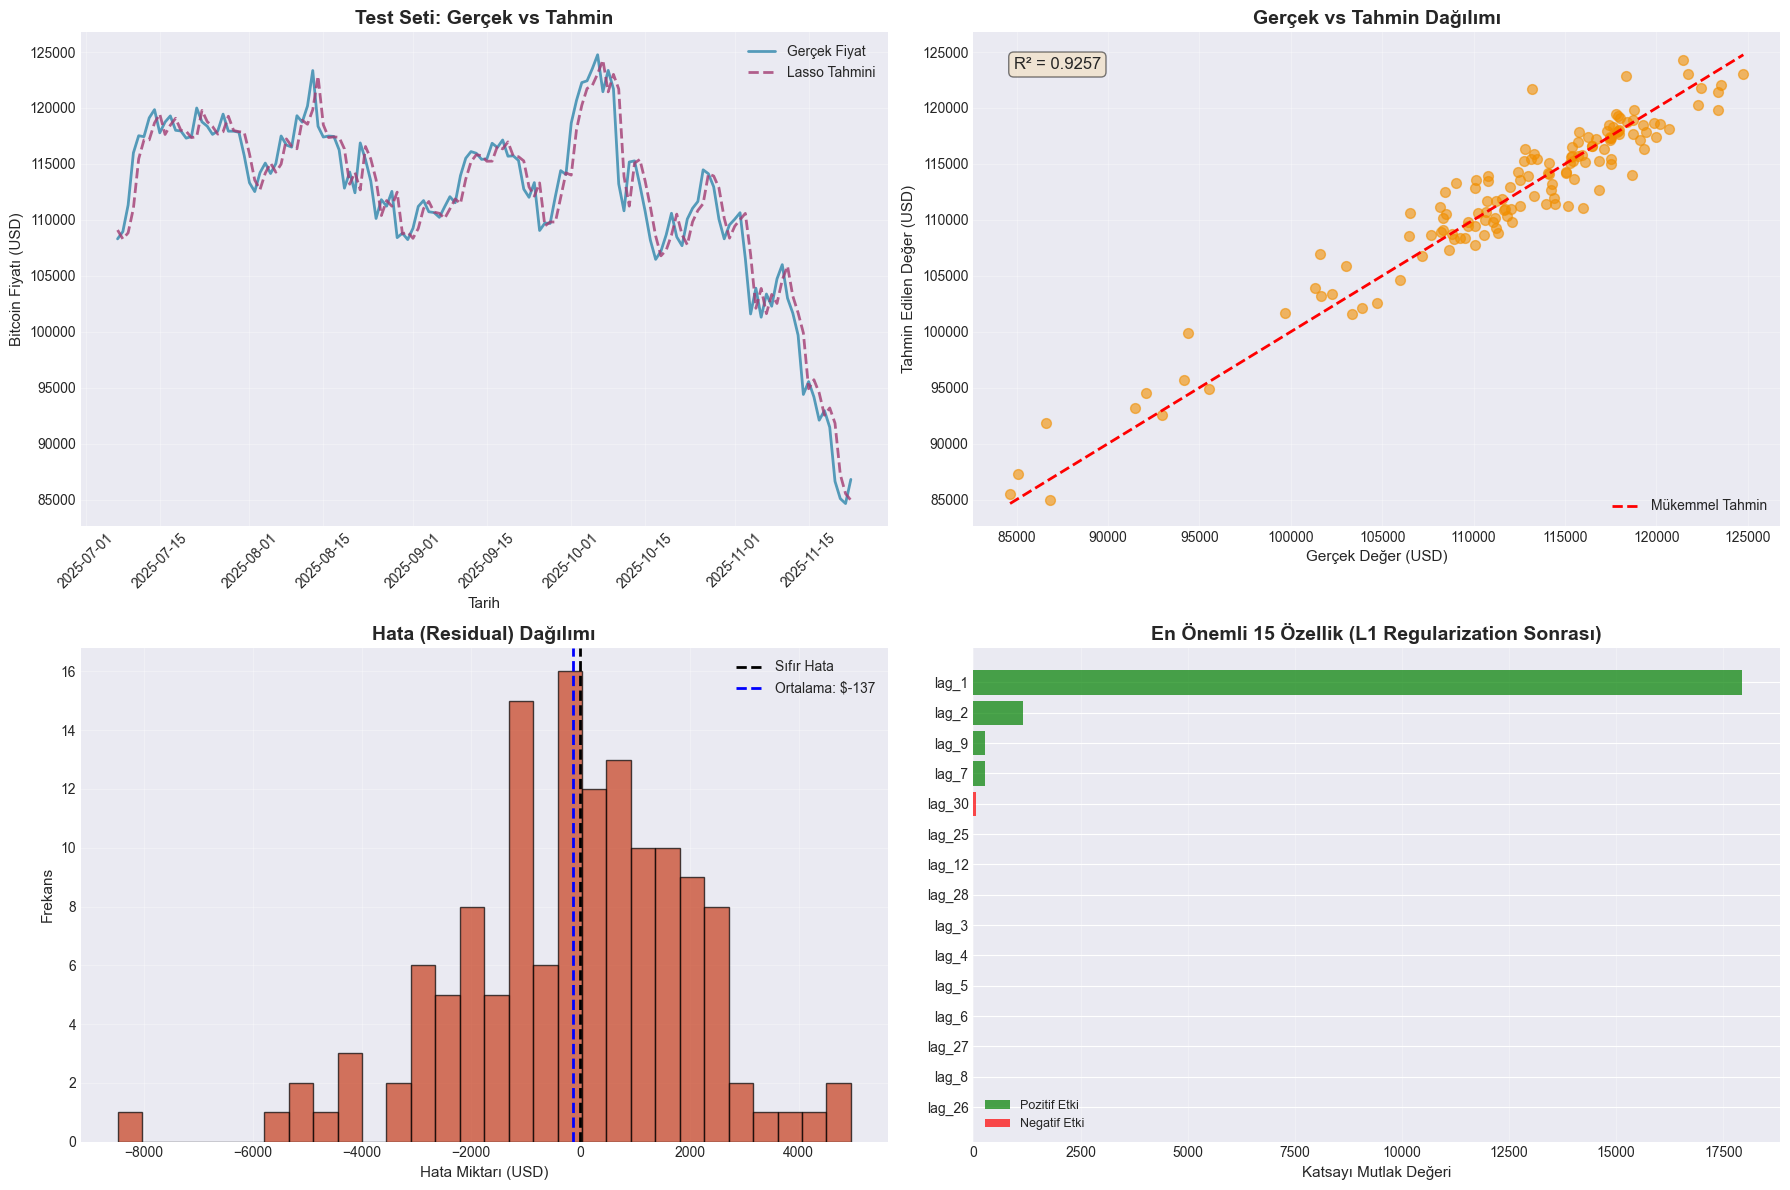


FEATURE SELECTION ÖZET (LASSO'NUN GÜC)
✓ Lasso'nun seçtiği en önemli özellikler:
    1. lag_1      - Katsayı: +17928.488467
    2. lag_2      - Katsayı: +1166.868625
    3. lag_9      - Katsayı: +280.609652
    4. lag_7      - Katsayı: +278.406308
    5. lag_30     - Katsayı: -70.803105


In [27]:
# 7. GÖRSELLEŞTİRME VE ANALIZ
# Sonuçları grafiklerle görselleştiriyorum
print("\n" + "=" * 70)
print("7. ADIM: GÖRSELLEŞTİRME")
print("=" * 70)

fig = plt.figure(figsize=(18, 12))

# Grafik 1: Gerçek vs Tahmin Edilen Fiyatlar
ax1 = plt.subplot(2, 2, 1)
plt.plot(test_dates, y_test.values, label='Gerçek Fiyat', 
         color='#2E86AB', linewidth=2, alpha=0.8)
plt.plot(test_dates, y_pred_test, label='Lasso Tahmini', 
         color='#A23B72', linewidth=2, linestyle='--', alpha=0.8)
plt.title('Test Seti: Gerçek vs Tahmin', fontsize=14, fontweight='bold')
plt.xlabel('Tarih', fontsize=11)
plt.ylabel('Bitcoin Fiyatı (USD)', fontsize=11)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)

# Grafik 2: Scatter Plot (Regresyon Performansı)
ax2 = plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.6, s=50, color='#F18F01')
# Mükemmel tahmin çizgisi (45 derece)
min_val, max_val = y_test.min(), y_test.max()
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Mükemmel Tahmin')
plt.title('Gerçek vs Tahmin Dağılımı', fontsize=14, fontweight='bold')
plt.xlabel('Gerçek Değer (USD)', fontsize=11)
plt.ylabel('Tahmin Edilen Değer (USD)', fontsize=11)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
# R² değerini grafiğe ekle
plt.text(0.05, 0.95, f'R² = {metrics_test[2]:.4f}', 
         transform=ax2.transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Grafik 3: Hata (Residual) Dağılımı
residuals = y_test.values - y_pred_test
ax3 = plt.subplot(2, 2, 3)
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='#C73E1D')
plt.axvline(0, color='black', linestyle='--', linewidth=2, label='Sıfır Hata')
plt.axvline(residuals.mean(), color='blue', linestyle='--', linewidth=2, 
            label=f'Ortalama: ${residuals.mean():.0f}')
plt.title('Hata (Residual) Dağılımı', fontsize=14, fontweight='bold')
plt.xlabel('Hata Miktarı (USD)', fontsize=11)
plt.ylabel('Frekans', fontsize=11)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# Grafik 4: Lasso Katsayıları (Feature Importance)
ax4 = plt.subplot(2, 2, 4)
# Sıfır olmayan katsayıları al
coef_series = pd.Series(model.coef_, index=feature_cols_final)
# Mutlak değere göre sırala (en önemliler)
coef_series_sorted = coef_series.abs().sort_values(ascending=True)
# Son 15 tanesini göster
top_features = coef_series_sorted.tail(15)
colors = ['green' if coef_series[feat] > 0 else 'red' for feat in top_features.index]
plt.barh(range(len(top_features)), top_features.values, color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features.index)
plt.title('En Önemli 15 Özellik (L1 Regularization Sonrası)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Katsayı Mutlak Değeri', fontsize=11)
plt.grid(alpha=0.3, axis='x')
# Renk açıklaması
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', alpha=0.7, label='Pozitif Etki'),
                   Patch(facecolor='red', alpha=0.7, label='Negatif Etki')]
plt.legend(handles=legend_elements, fontsize=9)

plt.tight_layout()
plt.savefig('model_performans_analizi.png', dpi=300, bbox_inches='tight')
print("\n✓ Grafik 'model_performans_analizi.png' olarak kaydedildi.")
plt.show()

# Feature selection sonuçlarını özetle
print("\n" + "=" * 70)
print("FEATURE SELECTION ÖZET (LASSO'NUN GÜC)")
print("=" * 70)
print(f"✓ Lasso'nun seçtiği en önemli özellikler:")
important_features = coef_series[coef_series != 0].abs().sort_values(ascending=False)
for i, (feat, coef) in enumerate(important_features.head(10).items(), 1):
    print(f"   {i:2d}. {feat:10s} - Katsayı: {coef_series[feat]:+.6f}")

In [28]:
# 8. GELECEK TAHMİNİ (RECURSIVE FORECASTING)
# Modeli kullanarak gelecek 30 günün fiyatlarını tahmin ediyorum
print("\n" + "=" * 70)
print("8. ADIM: GELECEK 30 GÜN TAHMİNİ")
print("=" * 70)

print("\nRECURSIVE FORECASTING:")
print("   • Her gün tahmini bir sonraki günün tahmini için kullanılır")
print("   • Yani: tahmin → yeni özellik → tekrar tahmin → ...")
print("   • Uzun vadede hata birikebilir, dikkatli yorumlanmalı!")

future_predictions = []

# Son 30 günün gerçek fiyatlarını al (sliding window)
last_window = y.iloc[-len(feature_cols_final):].values

print(f"\n✓ Son {len(feature_cols_final)} günlük veriyi kullanarak başlıyorum...")
print(f"✓ 30 gün boyunca recursive tahmin yapıyorum...")

# 30 gün için döngü
for day in range(1, 31):
    # 1. Mevcut pencereyi al ve ölçeklendir
    current_input = last_window.reshape(1, -1)
    current_input_scaled = scaler.transform(current_input)
    
    # 2. Tahmin yap
    next_pred = model.predict(current_input_scaled)[0]
    
    # 3. Tahmini kaydet
    future_predictions.append(next_pred)
    
    # 4. Sliding window'u kaydır: En eski değeri at, yeni tahmini ekle
    last_window = np.roll(last_window, -1)  # Tüm değerleri 1 sola kaydır
    last_window[-1] = next_pred              # Son pozisyona yeni tahmini ekle
    
    if day % 10 == 0:
        print(f"   ✓ {day} gün tamamlandı...")

print(f"\n✓ 30 günlük recursive tahmin tamamlandı!")
print(f"✓ İlk tahmin: ${future_predictions[0]:,.2f}")
print(f"✓ Son tahmin: ${future_predictions[-1]:,.2f}")
print(f"✓ Değişim: ${future_predictions[-1] - future_predictions[0]:+,.2f} " +
      f"(%{((future_predictions[-1]/future_predictions[0])-1)*100:+.2f})")


8. ADIM: GELECEK 30 GÜN TAHMİNİ

RECURSIVE FORECASTING:
   • Her gün tahmini bir sonraki günün tahmini için kullanılır
   • Yani: tahmin → yeni özellik → tekrar tahmin → ...
   • Uzun vadede hata birikebilir, dikkatli yorumlanmalı!

✓ Son 30 günlük veriyi kullanarak başlıyorum...
✓ 30 gün boyunca recursive tahmin yapıyorum...
   ✓ 10 gün tamamlandı...
   ✓ 20 gün tamamlandı...
   ✓ 30 gün tamamlandı...

✓ 30 günlük recursive tahmin tamamlandı!
✓ İlk tahmin: $111,801.98
✓ Son tahmin: $89,000.76
✓ Değişim: $-22,801.22 (%-20.39)



9. ADIM: TAHMİNLERİ KAYDETME VE GÖRSELLEŞTİRME

✓ Tahminler 'btc_30_day_forecast.csv' dosyasına kaydedildi.

Gelecek 30 Günlük Tahmin (İlk 10 gün):
      Date  Forecast_Close
2025-11-24   111801.978505
2025-11-25   114217.840447
2025-11-26   113756.108050
2025-11-27   112501.506028
2025-11-28   109653.564656
2025-11-29   108206.605749
2025-11-30   109328.583943
2025-12-01   109885.204086
2025-12-02   110167.606647
2025-12-03   106138.021723

✓ Tahmin grafiği oluşturuluyor...
✓ Grafik 'future_forecast_plot.png' olarak kaydedildi.


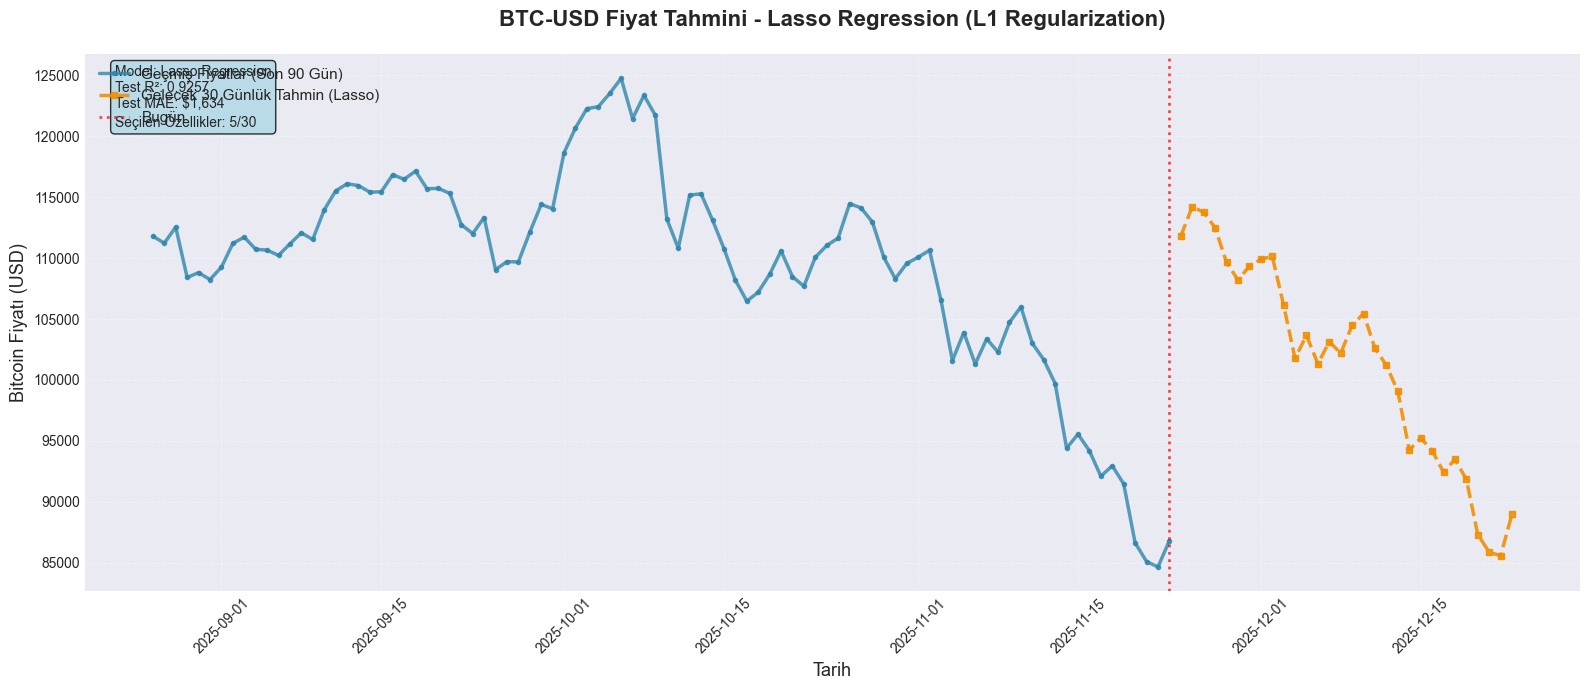


ÖZET:
   • Kullanılan Model: Lasso Regression (L1 Regularization)
   • Veri Seti: 730 günlük Bitcoin verisi
   • Başlangıç Özellik: 30
   • Correlation Selection Sonrası: 30
   • Variance Threshold Sonrası: 30
   • Lasso'nun Seçtiği Özellikler: 5
   • Test R²: 0.9257
   • Test MAE: $1,633.75
   • Gelecek 30 Gün Tahmini: Tamamlandı ✓

FEATURE SELECTION BAŞARISI:
   • İlk özellik sayısı: 30
   • Son özellik sayısı: 5
   • İndirgeme oranı: %83.3
   • Lasso'nun L1 regularization sayesinde gereksiz 25 özellik elendi!



In [29]:
# 9. TAHMİNLERİ KAYDETME VE GÖRSELLEŞTİRME
print("\n" + "=" * 70)
print("9. ADIM: TAHMİNLERİ KAYDETME VE GÖRSELLEŞTİRME")
print("=" * 70)

# Gelecek 30 günün tarihlerini oluştur
last_real_date = data_full['Date'].iloc[-1]
future_dates = [last_real_date + timedelta(days=i) for i in range(1, 31)]

# Tahminleri DataFrame'e dönüştür
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecast_Close': future_predictions
})

# CSV dosyası olarak kaydet
forecast_df.to_csv('btc_30_day_forecast.csv', index=False, date_format='%Y-%m-%d')
print("\n✓ Tahminler 'btc_30_day_forecast.csv' dosyasına kaydedildi.")

# İlk 10 günü göster
print("\nGelecek 30 Günlük Tahmin (İlk 10 gün):")
print(forecast_df.head(10).to_string(index=False))

# Görselleştirme
print("\n✓ Tahmin grafiği oluşturuluyor...")
plt.figure(figsize=(16, 7))

# Son 90 günlük gerçek fiyatlar
history_window = 90
history_dates = data_full['Date'].iloc[-history_window:]
history_close = data_full['Close'].iloc[-history_window:]

plt.plot(history_dates, history_close, 
         label='Geçmiş Fiyatlar (Son 90 Gün)', 
         color='#2E86AB', linewidth=2.5, marker='o', markersize=3, alpha=0.8)

# Gelecek 30 günlük tahminler
plt.plot(forecast_df['Date'], forecast_df['Forecast_Close'], 
         label='Gelecek 30 Günlük Tahmin (Lasso)', 
         color='#F18F01', linewidth=2.5, linestyle='--', marker='s', markersize=5, alpha=0.9)

# Geçiş noktasını işaretle
plt.axvline(x=last_real_date, color='red', linestyle=':', linewidth=2, 
            label='Bugün', alpha=0.7)

plt.title('BTC-USD Fiyat Tahmini - Lasso Regression (L1 Regularization)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Tarih', fontsize=13)
plt.ylabel('Bitcoin Fiyatı (USD)', fontsize=13)
plt.legend(fontsize=11, loc='upper left')
plt.grid(alpha=0.3, linestyle='--')
plt.xticks(rotation=45)

# İstatistikleri grafiğe ekle
stats_text = f"Model: Lasso Regression\n"
stats_text += f"Test R²: {metrics_test[2]:.4f}\n"
stats_text += f"Test MAE: ${metrics_test[1]:,.0f}\n"
stats_text += f"Seçilen Özellikler: {non_zero_coefs}/{len(feature_cols_final)}"
plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.savefig('future_forecast_plot.png', dpi=300, bbox_inches='tight')
print("✓ Grafik 'future_forecast_plot.png' olarak kaydedildi.")
plt.show()

# Final özet
print("=" * 70)
print("\nÖZET:")
print(f"   • Kullanılan Model: Lasso Regression (L1 Regularization)")
print(f"   • Veri Seti: {len(data_full)} günlük Bitcoin verisi")
print(f"   • Başlangıç Özellik: {n_lags}")
print(f"   • Correlation Selection Sonrası: {len(selected_features_corr)}")
print(f"   • Variance Threshold Sonrası: {len(feature_cols_final)}")
print(f"   • Lasso'nun Seçtiği Özellikler: {non_zero_coefs}")
print(f"   • Test R²: {metrics_test[2]:.4f}")
print(f"   • Test MAE: ${metrics_test[1]:,.2f}")
print(f"   • Gelecek 30 Gün Tahmini: Tamamlandı ✓")

print("\nFEATURE SELECTION BAŞARISI:")
print(f"   • İlk özellik sayısı: {n_lags}")
print(f"   • Son özellik sayısı: {non_zero_coefs}")
print(f"   • İndirgeme oranı: %{(1-non_zero_coefs/n_lags)*100:.1f}")
print(f"   • Lasso'nun L1 regularization sayesinde gereksiz {n_lags-non_zero_coefs} özellik elendi!")

print("\n" + "=" * 70)